In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from raw_utils import *
from alignment import *
import rawpy
from dataset_navigation import get_image_paths

In [9]:


def compute_local_variance_single_channel(image, kernel_size=5):
    image = image.astype(np.float64)
    # cv2 blur calculates local mean using a box filter
    mean = cv2.blur(image, (kernel_size, kernel_size))
    mean_sq = cv2.blur(image**2, (kernel_size, kernel_size))
    variance = mean_sq - mean**2
    return variance

def compute_local_variance(image, kernel_size=5):
    R_variance = compute_local_variance_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_variance_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_variance_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_variance_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)

def compute_local_mean_single_channel(image, kernel_size=5):
    image = image.astype(np.float64)
    # cv2 blur calculates local mean using a box filter
    mean = cv2.blur(image, (kernel_size, kernel_size))
    return mean

def compute_local_mean(image, kernel_size=5):
    R_variance = compute_local_mean_single_channel(image[:, :, 0], kernel_size)
    G1_variance = compute_local_mean_single_channel(image[:, :, 1], kernel_size)
    B_variance = compute_local_mean_single_channel(image[:, :, 2], kernel_size)
    G2_variance = compute_local_mean_single_channel(image[:, :, 3], kernel_size)

    return np.stack((R_variance, G1_variance, B_variance, G2_variance), axis=2)


def create_array_per_pair(image, variance_difference):
    image = image.flatten()
    variance_difference = variance_difference.flatten()
    if image.shape != variance_difference.shape:
        raise ValueError("Inputs must have the same shape after flattening.")
    paired_array = np.stack((image, variance_difference), axis=1)
    return paired_array

def average_y_per_x(paired_array, threshold=0):
    x = paired_array[:, 0]
    y = paired_array[:, 1]
    unique_x, inverse_indices = np.unique(x, return_inverse=True)
    sum_y = np.bincount(inverse_indices, weights=y)
    count_y = np.bincount(inverse_indices)
    avg_y = sum_y / count_y
    # Apply threshold
    mask = count_y >= threshold
    filtered_x = unique_x[mask]
    filtered_avg_y = avg_y[mask]
    return np.stack((filtered_x, filtered_avg_y), axis=1)

def average_y_per_x_binned(paired_array, num_bins=100, threshold=0):
    x = paired_array[:, 0]
    y = paired_array[:, 1]

    # Create bins
    x_min, x_max = x.min(), x.max()
    bins = np.linspace(x_min, x_max, num_bins + 1)

    # Assign each x to a bin
    bin_indices = np.digitize(x, bins) - 1  # shift to 0-based index

    # Remove out-of-range values
    valid_mask = (bin_indices >= 0) & (bin_indices < num_bins)
    bin_indices = bin_indices[valid_mask]
    y = y[valid_mask]

    # Compute average y per bin
    sum_y = np.bincount(bin_indices, weights=y, minlength=num_bins)
    count_y = np.bincount(bin_indices, minlength=num_bins)
    avg_y = np.divide(sum_y, count_y, out=np.zeros_like(sum_y), where=count_y > 0)

    # Apply threshold
    mask = count_y >= threshold
    bin_centers = (bins[:-1] + bins[1:]) / 2
    filtered_x = bin_centers[mask]
    filtered_avg_y = avg_y[mask]

    return np.stack((filtered_x, filtered_avg_y), axis=1)



In [5]:
from dataset_navigation import get_image_paths
from tqdm import tqdm
paths_dict = get_image_paths()
# n = 2
# diffused_image_paths = paths_dict['filter_long_exp'][:n]
# clear_image_paths = paths_dict['long_exp'][:n]

diffused_image_paths = paths_dict['filter_long_exp']
clear_image_paths = paths_dict['long_exp']

pixels_r = np.zeros(0)
pixel_to_variance_difference_r = np.zeros((0,2))
pixel_to_mean_difference_r = np.zeros((0,2))
pixel_to_variance_difference_normalized_r = np.zeros((0,2))
pixel_to_variance_clear_r = np.zeros((0,2))
pixel_to_variance_diffused_r = np.zeros((0,2))

for diffused_image_path, clear_image_path in tqdm(zip(diffused_image_paths, clear_image_paths), total=len(diffused_image_paths)):
    clear, diffused = align_and_crop_raw_images(clear_image_path, diffused_image_path)
    clear_channels = clear['channels']
    diffused_channels = diffused['channels']
    clear_variance = compute_local_variance(clear_channels)
    diffused_variance = compute_local_variance(diffused_channels)
    clear_mean = compute_local_mean(clear_channels)
    diffused_mean = compute_local_mean(diffused_channels)
    mean_difference = (diffused_mean - clear_mean)
    variance_difference_normalized = (diffused_variance - clear_variance ) / ( clear_variance + diffused_variance + 1e-8)
    variance_difference = (diffused_variance - clear_variance)
    pixels_r = np.append(pixels_r, clear_channels[:,:,0].flatten())
    pixel_to_mean_difference_r = np.append(pixel_to_mean_difference_r, create_array_per_pair(clear_channels[:,:,0], mean_difference[:,:,0]), axis=0)
    pixel_to_variance_difference_r = np.append(pixel_to_variance_difference_r, create_array_per_pair(clear_channels[:,:,0], variance_difference[:,:,0]), axis=0)
    pixel_to_variance_difference_normalized_r = np.append(pixel_to_variance_difference_normalized_r, create_array_per_pair(clear_channels[:,:,0], variance_difference_normalized[:,:,0]), axis=0)
    pixel_to_variance_clear_r = np.append(pixel_to_variance_clear_r, create_array_per_pair(clear_channels[:,:,0], clear_variance[:,:,0]), axis=0)
    pixel_to_variance_diffused_r = np.append(pixel_to_variance_diffused_r, create_array_per_pair(clear_channels[:,:,0], diffused_variance[:,:,0]), axis=0)
print(pixel_to_variance_difference_r.shape)

  0%|          | 0/237 [00:02<?, ?it/s]


KeyError: 'channels'

In [6]:
def plot_scatter(paired_array, ax, xlabel="", ylabel="", title=""):
    x = paired_array[:, 0]
    y = paired_array[:, 1]
    ax.scatter(x, y, s=1, alpha=0.8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

def plot_avg_variance_difference_by_pixel_1_channel(variance_difference_by_pixel_compared_to_original, threshold=0, ax=None):
    # avg_variance_by_pixel_compared_to_original = average_y_per_x(variance_difference_by_pixel_compared_to_original, threshold=threshold)
    avg_variance_by_pixel_compared_to_original = average_y_per_x_binned(variance_difference_by_pixel_compared_to_original, num_bins=500, threshold=threshold)
    if ax is None:
        fig, ax = plt.subplots()
    plot_scatter(avg_variance_by_pixel_compared_to_original, ax, "Pixel intensity", "Avg variance difference", "Avg variance difference by pixel intensity")

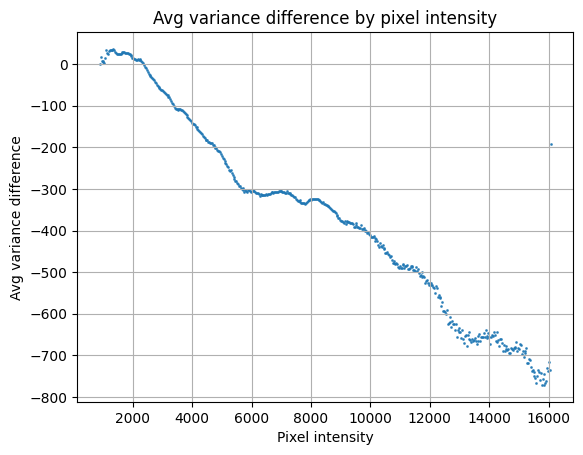

In [7]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_mean_difference_r)


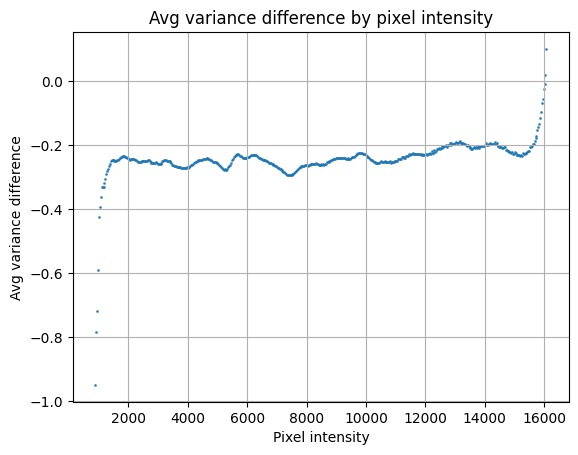

In [8]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_difference_normalized_r)

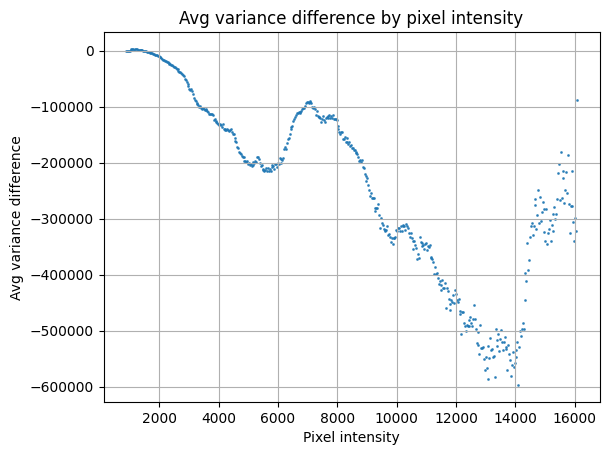

In [9]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_difference_r)


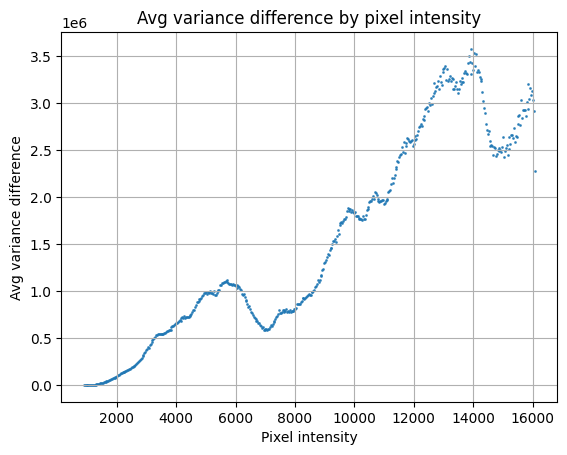

In [10]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_clear_r)

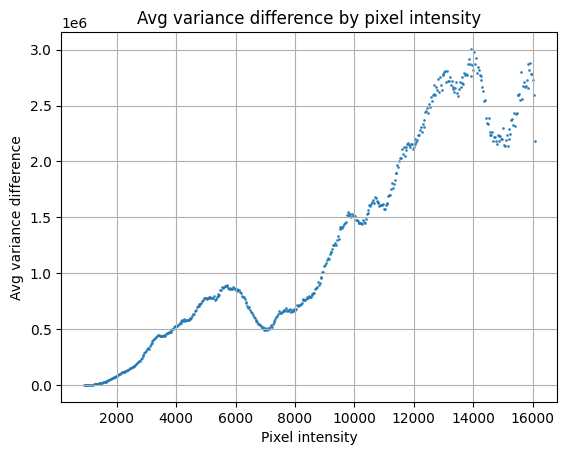

In [11]:
plot_avg_variance_difference_by_pixel_1_channel(pixel_to_variance_diffused_r)


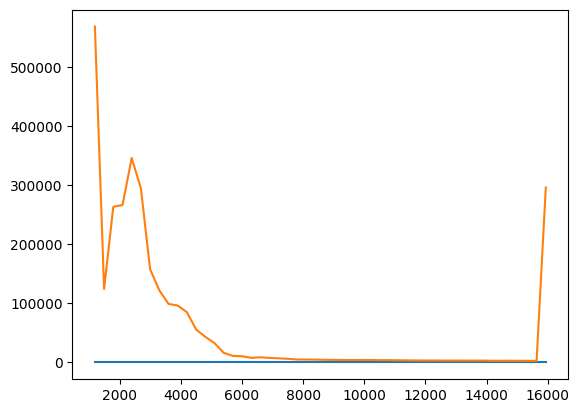

In [47]:

# simply plot avg brightness histogram
num_bins = 50

# print(np.allclose(pixel_to_variance_difference_r[:, 0], pixels_r))

counts, bin_edges = np.histogram(pixel_to_variance_difference_r[:, 0], bins=num_bins)
# counts, bin_edges = np.histogram(pixels_r, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)

# Plot as points
plt.plot(bin_centers, inv_counts)
plt.plot(bin_centers, counts)
# plt.hist(pixel_to_variance_difference_r[:, 0], bins=num_bins)
# plt.plot(bins, hist)
plt.show()

## Simple example on a single image
In this example you can just about see the inverse relationship between the number of pixel of a certain brightness level and the variance around that brightness level.
It is however very noisy as we are only processing a single image. This example uses simple to understand code.
In the next sample we process all the images, using slightly more complex functions to calculate the averages for faster processing. 

In [45]:
# Load image and flatten
path_to_raw = './dataset_raw/long_exp/photo_2 (2).CR2'
red_channel = pack_raw(rawpy.imread(path_to_raw))[:,:,0]
image_flat = red_channel.flatten()
image_flat = image_flat[image_flat != image_flat.max()]

# Compute avg variance per pixel brightness level
variances = compute_local_variance_single_channel(red_channel, kernel_size=5)
variances_flat = variances.flatten()

brightness_variances = {}

for i in range(image_flat.max()+1):
    brightness_variances[np.uint16(i)] = []
for i in range(len(image_flat)):
    brightness = image_flat[i]
    variance = variances_flat[i]
    brightness_variances[brightness].append(variance)

brightness_avg_variances = {}
brightness_values = []
for brightness, variances in brightness_variances.items():
    if len(variances) == 0: continue
    brightness_avg_variances[brightness] = sum(variances)/len(variances)
    
# Plot graphs
num_bins = 50

counts, bin_edges = np.histogram(image_flat, bins=num_bins)
# counts, bin_edges = np.histogram(pixels_r, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)

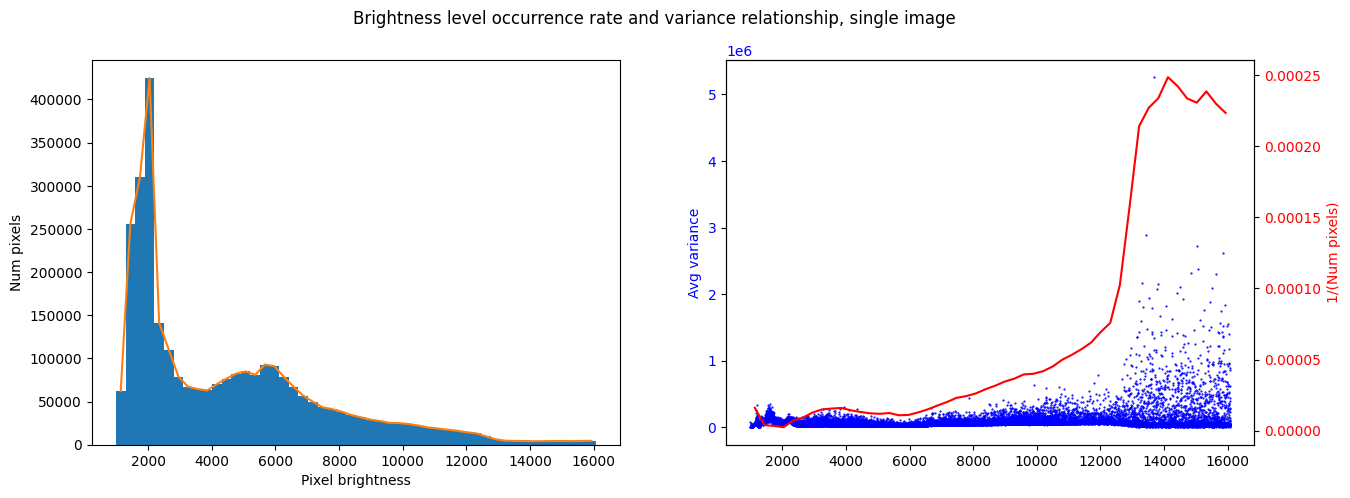

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Brightness level occurrence rate and variance relationship, single image")
ax[0].hist(image_flat, bins=num_bins, log=False)
ax[0].plot(bin_centers, counts)
ax[0].set_ylabel("Num pixels")
ax[0].set_xlabel("Pixel brightness")
ax1_twin = ax[1].twinx()
ax1_twin.plot(bin_centers, inv_counts, color='red')
ax1_twin.set_ylabel("1/(Num pixels)", color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax[1].scatter(list(brightness_avg_variances.keys()), list(brightness_avg_variances.values()), s=0.3, color='blue')
ax[1].tick_params(axis='y', labelcolor='blue')
ax[1].set_ylabel("Avg variance", color='blue')
ax1_twin.set_xlabel("Pixel brightness")

plt.show()

## Same idea but for all image concatenated together for a better converged example
Here we process all the images in our dataset, we see that the relationship becomes a lot clearer.

In [54]:

from dataset_navigation import get_image_paths
from raw_utils import pack_raw
from tqdm import tqdm
paths_dict = get_image_paths()
# n = 2
# diffused_image_paths = paths_dict['filter_long_exp'][:n]
# clear_image_paths = paths_dict['long_exp'][:n]

clear_image_paths = paths_dict['long_exp']
pixel_to_variance_clear_r = np.zeros((0,2))

for clear_image_path in tqdm(clear_image_paths, total=len(clear_image_paths)):
    clear_channels = pack_raw(rawpy.imread(clear_image_path))    
    clear_variance = compute_local_variance(clear_channels)
    pixel_to_variance_clear_r = np.append(pixel_to_variance_clear_r, create_array_per_pair(clear_channels[:,:,0], clear_variance[:,:,0]), axis=0)


{'photo_33.CR2', 'photo_8.CR2'}


100%|██████████| 44/44 [00:33<00:00,  1.30it/s]


In [42]:

images_flat = pixel_to_variance_clear_r[:, 0]
variances_flat = pixel_to_variance_clear_r[:, 1]
# Here we can't use the dictionary approach anymore because it is too slow to process all the pixels for all the images.
# Instead we use our complicated average_y_per_x function to calculate the pixel value for each 

# Minimum number of locations of a brightness level to be included in the statistics.
threshold = 0
avg_y_per_x = average_y_per_x(pixel_to_variance_clear_r, threshold=threshold)

num_bins = 100

counts, bin_edges = np.histogram(images_flat, bins=num_bins)
# counts, bin_edges = np.histogram(pixels_r, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
inv_counts = np.where(counts != 0, 1 / counts, 0)


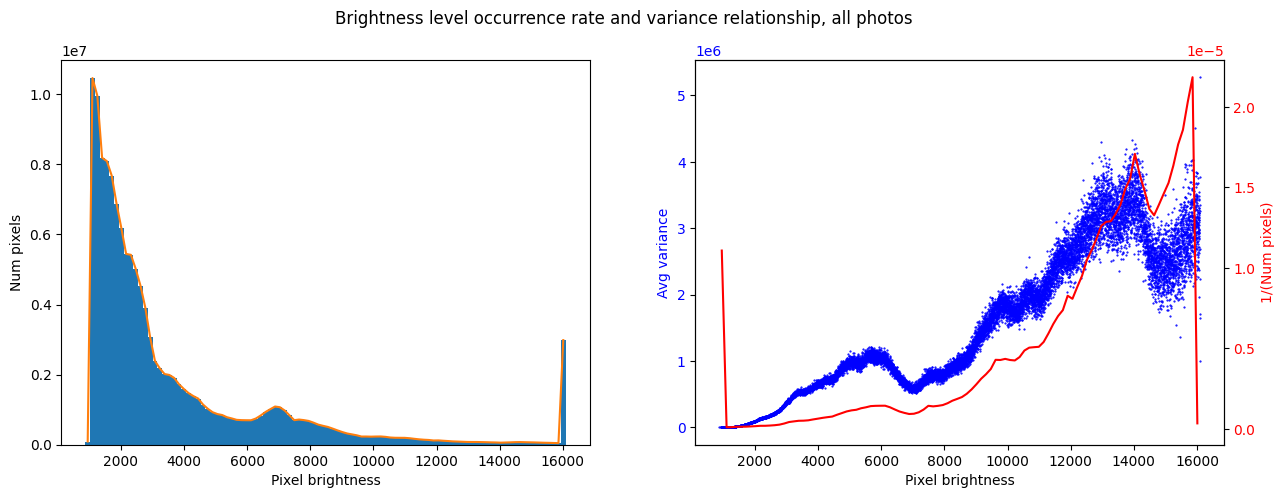

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Brightness level occurrence rate and variance relationship, all photos")
ax[0].hist(images_flat, bins=num_bins, log=False)
ax[0].plot(bin_centers, counts)
ax[0].set_ylabel("Num pixels")
ax[0].set_xlabel("Pixel brightness")
ax1_twin = ax[1].twinx()
ax1_twin.plot(bin_centers, inv_counts, color='red')
ax1_twin.set_ylabel("1/(Num pixels)", color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax[1].scatter(avg_y_per_x[:,0], avg_y_per_x[:,1], s=0.3, color='blue')
ax[1].tick_params(axis='y', labelcolor='blue')
ax[1].set_ylabel("Avg variance", color='blue')
ax[1].set_xlabel("Pixel brightness")
ax1_twin.set_xlabel("Pixel brightness")

plt.show()

## Use python module that is multi threaded


### Look at variance difference

## Compare different color channels


In [2]:
import variance_brightness_analysis as vba

def get_avg_y_per_x_for_channel(channel):
    brightness_to_variance_difference_r = vba.get_brightness_to_variance_difference(channel=channel)
    threshold = 10
    avg_y_per_x = average_y_per_x(brightness_to_variance_difference_r, threshold=threshold)
    return avg_y_per_x

In [9]:

channel_to_plt_color = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'purple'
}

# Create data from scratch
# avg_y_per_x_r = get_avg_y_per_x_for_channel(0)
# avg_y_per_x_g1 = get_avg_y_per_x_for_channel(1)
# avg_y_per_x_b = get_avg_y_per_x_for_channel(2)
# avg_y_per_x_g2 = get_avg_y_per_x_for_channel(3)

# Load data from file
avg_y_per_x_r = np.load("avg_variance_difference_per_brightness_channel_0.npy")
avg_y_per_x_g1 = np.load("avg_variance_difference_per_brightness_channel_1.npy")
avg_y_per_x_b = np.load("avg_variance_difference_per_brightness_channel_2.npy")
avg_y_per_x_g2 = np.load("avg_variance_difference_per_brightness_channel_3.npy")

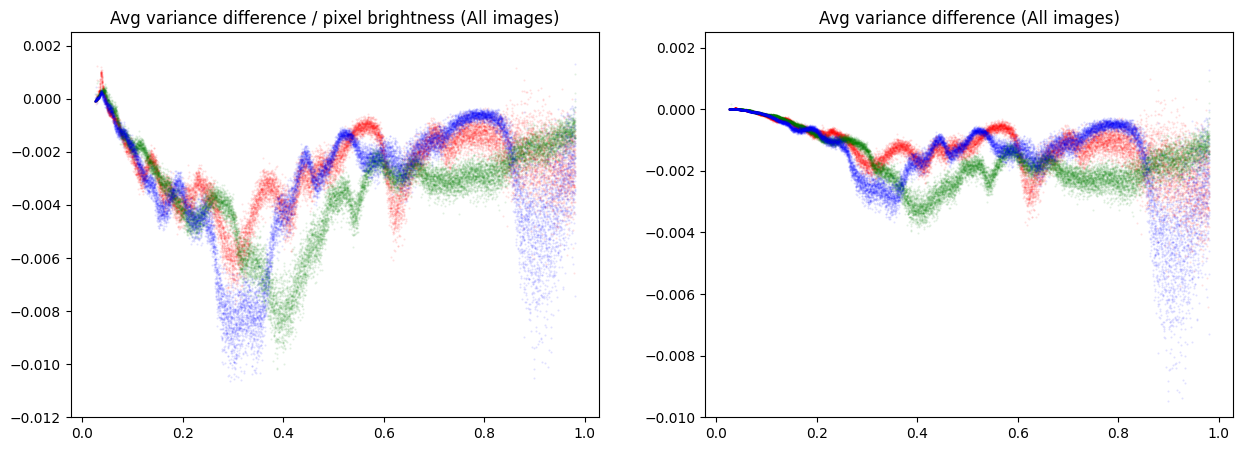

In [180]:
channel_results = [avg_y_per_x_r, avg_y_per_x_g1, avg_y_per_x_b, avg_y_per_x_g2]
fig, ax = plt.subplots(1,2, figsize=(15,5))
for channel in range(3):
    avg_y_per_x = channel_results[channel]
    ax[0].scatter(avg_y_per_x[:,0], avg_y_per_x[:,1]/avg_y_per_x[:,0], s=0.3, color=channel_to_plt_color[channel], label=f"Channel {channel}", alpha=0.1)
    ax[0].set_title(f"Avg variance difference / pixel brightness (All images)")
    ax[0].set_ylim(-0.012, 0.0025)
    ax[1].scatter(avg_y_per_x[:,0], avg_y_per_x[:,1], s=0.3, color=channel_to_plt_color[channel], label=f"Channel {channel}", alpha=0.1)
    ax[1].set_title(f"Avg variance difference (All images)")
    ax[1].set_ylim(-0.01, 0.0025)
plt.show()

In [181]:
# Save the different channels to a file
# for idx, channel_result in enumerate(channel_results):
#     np.save(f"avg_variance_difference_per_brightness_channel_{idx}.npy", channel_result)

In [42]:
from scipy.interpolate import UnivariateSpline
def fit_spline(avg_y_per_x_r, smoothing_factor=2e-3):
    spl = UnivariateSpline(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], s=smoothing_factor, k=5)
    return spl

In [183]:
# Fit splines to the data
spline_r = fit_spline(avg_y_per_x_r)
spline_g1 = fit_spline(avg_y_per_x_g1)
spline_b = fit_spline(avg_y_per_x_b)
spline_g2 = fit_spline(avg_y_per_x_g2)

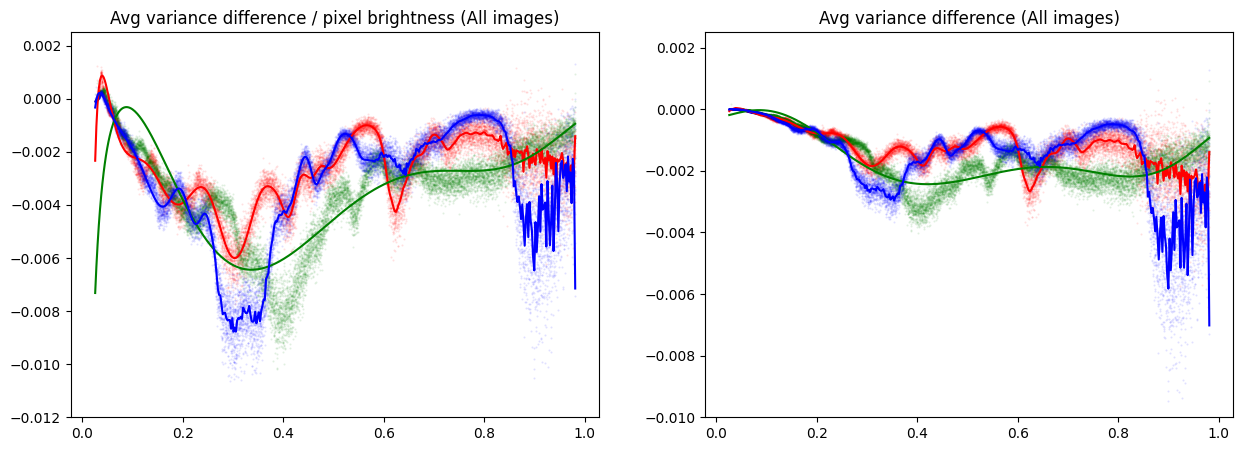

In [185]:
# Plot the original data and the fitted curve
# Note that the spline had problems in areas where there are large variances.
# This is fixed in the next cell by using a running median to smooth the data before fitting the spline.
fig, ax = plt.subplots(1,2, figsize=(15,5))
x_fit = np.linspace(avg_y_per_x_r[:,0].min(), avg_y_per_x_r[:,0].max(), 400)
y_fit_r = spline_r(x_fit)
y_fit_g1 = spline_g1(x_fit)
y_fit_b = spline_b(x_fit)
y_fit_g2 = spline_g2(x_fit)

ax[0].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1]/avg_y_per_x_r[:,0], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[0].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1]/avg_y_per_x_g1[:,0], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[0].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1]/avg_y_per_x_b[:,0], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[0].plot(x_fit, y_fit_r/x_fit, color='red')
ax[0].plot(x_fit, y_fit_g1/x_fit, color='green')
ax[0].plot(x_fit, y_fit_b/x_fit, color='blue')
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].set_ylim(-0.012, 0.0025)
ax[1].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[1].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[1].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[1].plot(x_fit, y_fit_r, color='red')
ax[1].plot(x_fit, y_fit_g1, color='green')
ax[1].plot(x_fit, y_fit_b, color='blue')
ax[1].set_title("Avg variance difference (All images)")
ax[1].set_ylim(-0.01, 0.0025)
plt.show()


In [40]:
# Do running median on the data
from scipy.ndimage import median_filter
def running_median(x, y, size=5):
    # Create a new array to hold the smoothed values
    smoothed_y = np.zeros_like(y)
    
    # Apply the median filter to the y values
    smoothed_y = median_filter(y, size=size)
    
    return smoothed_y

In [187]:

# Apply running median to the data
window_size = 200
smoothed_y_r = avg_y_per_x_r.copy()
smoothed_y_r[:,1] = running_median(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], size=window_size)
smoothed_y_g1 = avg_y_per_x_g1.copy()
smoothed_y_g1[:,1] = running_median(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1], size=window_size)
smoothed_y_b = avg_y_per_x_b.copy()
smoothed_y_b[:,1] = running_median(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1], size=window_size)
smoothed_y_g2 = avg_y_per_x_g2.copy()
smoothed_y_g2[:,1] = running_median(avg_y_per_x_g2[:,0], avg_y_per_x_g2[:,1], size=window_size)


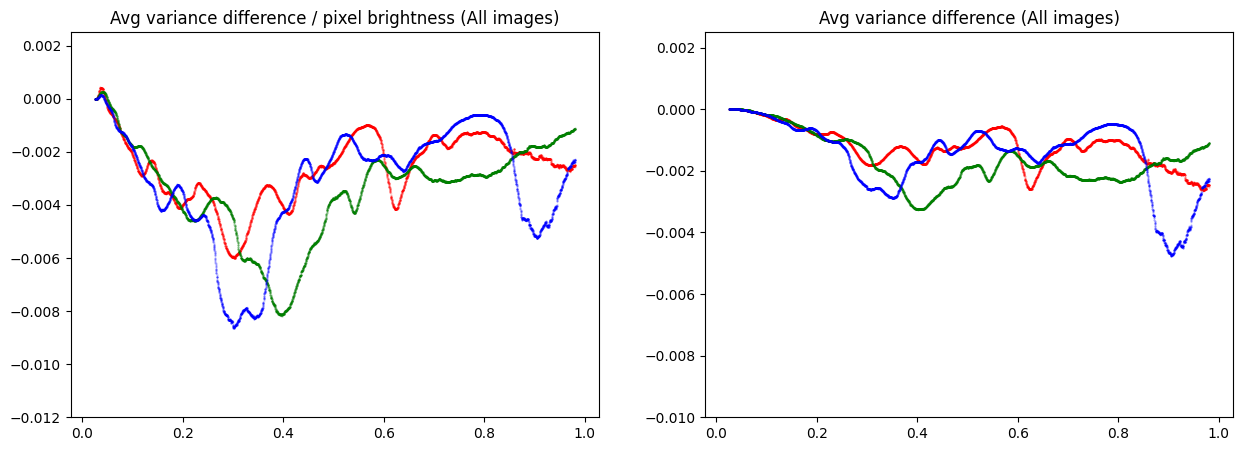

In [188]:
# Plot the smoothed data
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(smoothed_y_r[:,0], smoothed_y_r[:,1]/smoothed_y_r[:,0], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[0].scatter(smoothed_y_g1[:,0], smoothed_y_g1[:,1]/smoothed_y_g1[:,0], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[0].scatter(smoothed_y_b[:,0], smoothed_y_b[:,1]/smoothed_y_b[:,0], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].set_ylim(-0.012, 0.0025)
ax[1].scatter(smoothed_y_r[:,0], smoothed_y_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[1].scatter(smoothed_y_g1[:,0], smoothed_y_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[1].scatter(smoothed_y_b[:,0], smoothed_y_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[1].set_title("Avg variance difference (All images)")
ax[1].set_ylim(-0.01, 0.0025)
plt.show()



In [189]:
# Fit the spline to the smoothed data
smoothing_factor = 1e-5
spline_r = fit_spline(smoothed_y_r, smoothing_factor)
print("Found spline for channel 0")
spline_g1 = fit_spline(smoothed_y_g1, smoothing_factor)
print("Found spline for channel 1")
spline_b = fit_spline(smoothed_y_b, smoothing_factor)
print("Found spline for channel 2")
spline_g2 = fit_spline(smoothed_y_g2, smoothing_factor)
print("Found spline for channel 3")


Found spline for channel 0
Found spline for channel 1
Found spline for channel 2
Found spline for channel 3


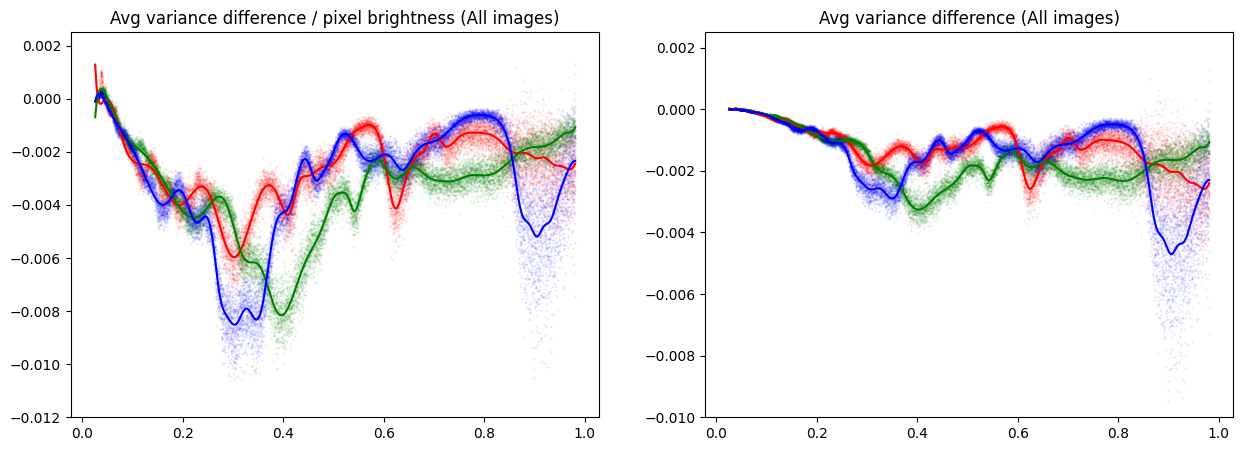

In [190]:
# Plot the original data and the fitted curve
fig, ax = plt.subplots(1,2, figsize=(15,5))
x_fit = np.linspace(smoothed_y_r[:,0].min(), smoothed_y_r[:,0].max(), 400)
y_fit_r = spline_r(x_fit)
y_fit_g1 = spline_g1(x_fit)
y_fit_b = spline_b(x_fit)
y_fit_g2 = spline_g2(x_fit)
ax[0].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1]/avg_y_per_x_r[:,0], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[0].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1]/avg_y_per_x_g1[:,0], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[0].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1]/avg_y_per_x_b[:,0], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[0].plot(x_fit, y_fit_r/x_fit, color='red')
ax[0].plot(x_fit, y_fit_g1/x_fit, color='green')
ax[0].plot(x_fit, y_fit_b/x_fit, color='blue')
ax[0].set_title("Avg variance difference / pixel brightness (All images)")
ax[0].set_ylim(-0.012, 0.0025)
ax[1].scatter(avg_y_per_x_r[:,0], avg_y_per_x_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
ax[1].scatter(avg_y_per_x_g1[:,0], avg_y_per_x_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
ax[1].scatter(avg_y_per_x_b[:,0], avg_y_per_x_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
ax[1].plot(x_fit, y_fit_r, color='red')
ax[1].plot(x_fit, y_fit_g1, color='green')
ax[1].plot(x_fit, y_fit_b, color='blue')
ax[1].set_title("Avg variance difference (All images)")
ax[1].set_ylim(-0.01, 0.0025)
plt.show()


Text(0, 0.5, 'std difference')

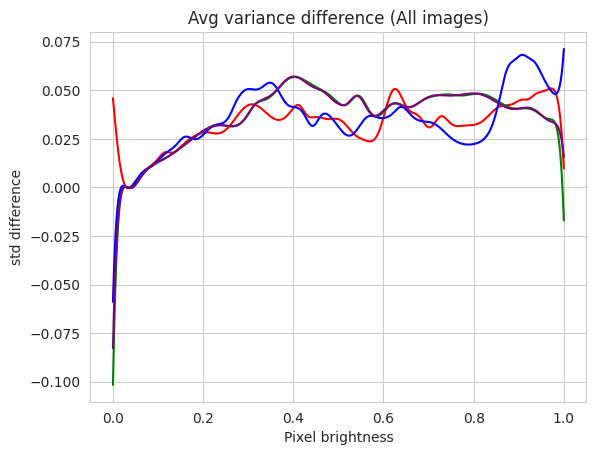

In [11]:
from variance_brightness_analysis import get_brightness_to_std_difference_splines
from matplotlib import pyplot as plt

# Get the splines for the different channels
splines = get_brightness_to_std_difference_splines()

# Plot the splines
x_fit = np.linspace(0, 1, 400)
for channel, spline in enumerate(splines):
    y_fit = spline(x_fit)
    plt.plot(x_fit, y_fit, color=channel_to_plt_color[channel], label=f"Channel {channel}")

plt.title("Avg variance difference (All images)")
plt.xlabel("Pixel brightness")
plt.ylabel("std difference")

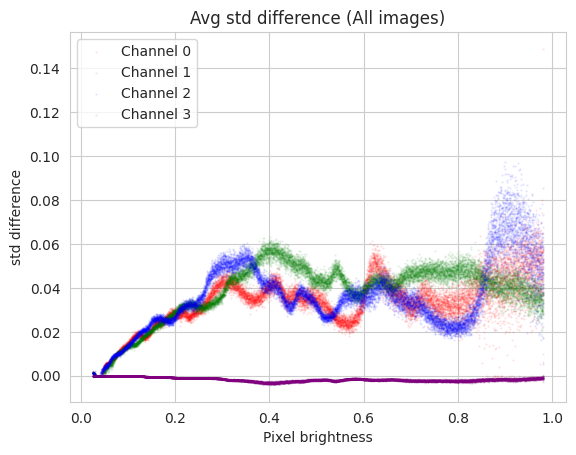

In [14]:

# Load the different channels from a file
var_diff_per_brightness_r = np.load("avg_variance_difference_per_brightness_channel_0.npy")
var_diff_per_brightness_g1 = np.load("avg_variance_difference_per_brightness_channel_1.npy")
var_diff_per_brightness_b = np.load("avg_variance_difference_per_brightness_channel_2.npy")
var_diff_per_brightness_g2 = np.load("avg_variance_difference_per_brightness_channel_3.npy")

std_diff_per_brightness_r = var_diff_per_brightness_r.copy()
std_diff_per_brightness_r[:,1] = np.sqrt(-np.clip(var_diff_per_brightness_r[:, 1], a_min=None, a_max=0))
std_diff_per_brightness_g1 = var_diff_per_brightness_g1.copy()
std_diff_per_brightness_g1[:,1] = np.sqrt(-np.clip(var_diff_per_brightness_g1[:, 1], a_min=None, a_max=0))
std_diff_per_brightness_b = var_diff_per_brightness_b.copy()
std_diff_per_brightness_b[:,1] = np.sqrt(-np.clip(var_diff_per_brightness_b[:, 1], a_min=None, a_max=0))
std_diff_per_brightness_g2 = var_diff_per_brightness_g2.copy()

# Plot the std difference per brightness
plt.scatter(std_diff_per_brightness_r[:,0], std_diff_per_brightness_r[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
plt.scatter(std_diff_per_brightness_g1[:,0], std_diff_per_brightness_g1[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
plt.scatter(std_diff_per_brightness_b[:,0], std_diff_per_brightness_b[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
plt.scatter(std_diff_per_brightness_g2[:,0], std_diff_per_brightness_g2[:,1], s=0.3, color='purple', label="Channel 3", alpha=0.1)
plt.title("Avg std difference (All images)")
plt.xlabel("Pixel brightness")
plt.ylabel("std difference")
plt.legend()
plt.show()


# Process each channel
# std_diff_smoothed_r = process_channel(var_diff_per_brightness_r)
# std_diff_smoothed_g1 = process_channel(var_diff_per_brightness_g1)
# std_diff_smoothed_b = process_channel(var_diff_per_brightness_b)
# std_diff_smoothed_g2 = process_channel(var_diff_per_brightness_g2)
# Fit splines to the smoothed data
# spl_r = fit_spline(std_diff_smoothed_r)
# spl_g1 = fit_spline(std_diff_smoothed_g1)
# spl_b = fit_spline(std_diff_smoothed_b)
# spl_g2 = fit_spline(std_diff_smoothed_g2)
#     Return the splines
#     return spl_r, spl_g1, spl_b, spl_g2

# Load std difference data

In [54]:
from variance_brightness_analysis import get_brightness_to_std_difference

# Get the std difference data for each channel
print("Loading std difference data...")
std_diff_per_brightness_r = average_y_per_x(get_brightness_to_std_difference(channel=0))
print("Loaded std difference data for channel 0")
std_diff_per_brightness_g1 = average_y_per_x(get_brightness_to_std_difference(channel=1))
print("Loaded std difference data for channel 1")
std_diff_per_brightness_b = average_y_per_x(get_brightness_to_std_difference(channel=2))
print("Loaded std difference data for channel 2")
std_diff_per_brightness_g2 = average_y_per_x(get_brightness_to_std_difference(channel=3))
print("Loaded std difference data for channel 3")



Loading std difference data...


  0%|          | 0/5 [00:00<?, ?it/s]

Num unique values in packed1: 14711
Num unique values in packed1: 15014
Num unique values in packed1: 14920
Num unique values in packed1: 15008
Num unique values in packed1: 13466
Num unique values in packed1: 14711
Num unique values in cropped_original: 14704
Num unique values in packed1: 14920
Num unique values in packed1: 15008
Num unique values in cropped_original: 14912
Num unique values in packed1: 15014
Num unique values in cropped_aligned: 3095542
Num unique values in cropped_original: 15008
Num unique values in packed1: 13466
Num unique values in cropped_original: 15005
Num unique values in cropped_aligned: 2784924
Num unique values in cropped_aligned: 2518914
Num unique values in cropped_original: 13333
Num unique values in cropped_aligned: 3406962
Num unique values in cropped_aligned: 2760466
Num unique values in cropped_original: 14912
Num unique values in cropped_original: 14704
Num unique values in cropped_aligned: 2784924
clear_ch unique values: 14912
Num unique values i

100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Loaded std difference data for channel 0


  0%|          | 0/5 [00:00<?, ?it/s]

Num unique values in packed1: 14711
Num unique values in packed1: 14920
Num unique values in packed1: 15014
Num unique values in packed1: 13466
Num unique values in packed1: 15008
Num unique values in packed1: 14711
Num unique values in cropped_original: 14704
Num unique values in packed1: 15014
Num unique values in cropped_original: 15005
Num unique values in packed1: 14920
Num unique values in cropped_aligned: 3095542
Num unique values in packed1: 13466
Num unique values in cropped_original: 14912
Num unique values in cropped_aligned: 3406962
Num unique values in cropped_original: 13333
Num unique values in packed1:Num unique values in cropped_aligned:  15008
2784924
Num unique values in cropped_aligned: 2760466
Num unique values in cropped_original: 15008
Num unique values in cropped_aligned: 2518914
Num unique values in cropped_original: 14704
Num unique values in cropped_aligned: 3095542
Num unique values in cropped_original: 15005
clear_ch unique values: 14704
Num unique values i

100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


Loaded std difference data for channel 1


  0%|          | 0/5 [00:00<?, ?it/s]

Num unique values in packed1: 14711
Num unique values in packed1: 14920
Num unique values in packed1: 15014
Num unique values in packed1: 15008
Num unique values in packed1: 13466
Num unique values in packed1: 14711
Num unique values in packed1: 13466
Num unique values in packed1: 15014
Num unique values in packed1: 14920
Num unique values in packed1: 15008Num unique values in cropped_original:
 14704
Num unique values in cropped_original: 13333
Num unique values in cropped_original: 15005
Num unique values in cropped_original: 14912
Num unique values in cropped_original: 15008
Num unique values in cropped_aligned: 3095542
Num unique values in cropped_aligned: 3406962
Num unique values in cropped_aligned: 2760466
Num unique values in cropped_aligned: 2784924
Num unique values in cropped_aligned: 2518914
Num unique values in cropped_original: 14704
Num unique values in cropped_aligned: 3095542
Num unique values in cropped_original: 15005
Num unique values in cropped_original: 14912
clea

100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Loaded std difference data for channel 2


  0%|          | 0/5 [00:00<?, ?it/s]

Num unique values in packed1: 14711
Num unique values in packed1: 15014
Num unique values in packed1: 14920
Num unique values in packed1: 15008
Num unique values in packed1: 13466
Num unique values in packed1: 14711
Num unique values in cropped_original: 14704
Num unique values in packed1: 14920
Num unique values in packed1: 15014
Num unique values in packed1: 13466
Num unique values in cropped_original: 14912
Num unique values in packed1: 15008
Num unique values in cropped_aligned: 3095542
Num unique values in cropped_original: 15005
Num unique values in cropped_original: 13333
Num unique values in cropped_original: 15008
Num unique values in cropped_aligned: 2784924
Num unique values in cropped_aligned: 3406962
Num unique values in cropped_aligned: 2760466
Num unique values in cropped_aligned: 2518914
Num unique values in cropped_original: 14704
Num unique values in cropped_aligned: 3095542
clear_ch unique values: 14704
Num unique values in cropped_original: 14912
Num unique values i

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


Loaded std difference data for channel 3


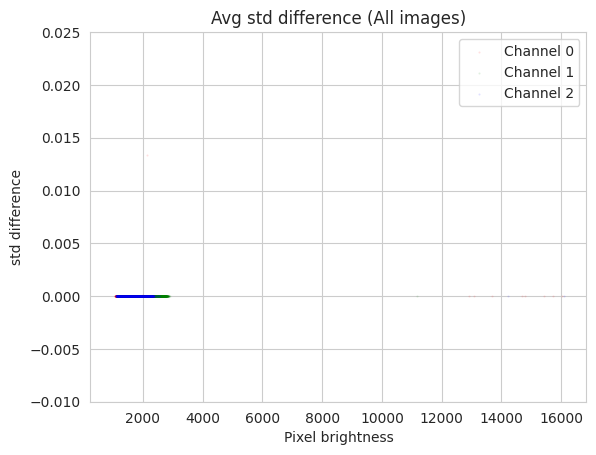

In [56]:
# Do negation and clipping to avoid negative values
std_diff_per_brightness_r_negated = std_diff_per_brightness_r.copy()
std_diff_per_brightness_g1_negated = std_diff_per_brightness_g1.copy()
std_diff_per_brightness_b_negated = std_diff_per_brightness_b.copy()
std_diff_per_brightness_g2_negated = std_diff_per_brightness_g2.copy()
std_diff_per_brightness_r_negated[:,1] = -np.clip(std_diff_per_brightness_r[:, 1], a_min=None, a_max=0)
std_diff_per_brightness_g1_negated[:,1] = -np.clip(std_diff_per_brightness_g1[:, 1], a_min=None, a_max=0)
std_diff_per_brightness_b_negated[:,1] = -np.clip(std_diff_per_brightness_b[:, 1], a_min=None, a_max=0)
std_diff_per_brightness_g2_negated[:,1] = -np.clip(std_diff_per_brightness_g2[:, 1], a_min=None, a_max=0)


# Plot the std difference data

plt.scatter(std_diff_per_brightness_r_negated[:,0], std_diff_per_brightness_r_negated[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
plt.scatter(std_diff_per_brightness_g1_negated[:,0], std_diff_per_brightness_g1_negated[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
plt.scatter(std_diff_per_brightness_b_negated[:,0], std_diff_per_brightness_b_negated[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
# plt.scatter(std_diff_per_brightness_g2[:,0], std_diff_per_brightness_g2[:,1], s=0.3, color='purple', label="Channel 3", alpha=0.1)
plt.ylim(-0.01, 0.025)
plt.title("Avg std difference (All images)")
plt.xlabel("Pixel brightness")
plt.ylabel("std difference")
plt.legend()
plt.show()

In [43]:
# Now median filter the data and fit the spline
# Apply running median to the data
window_size = 200
std_diff_per_brightness_r_negated_smoothed = std_diff_per_brightness_r_negated.copy()
std_diff_per_brightness_r_negated_smoothed[:,1] = running_median(std_diff_per_brightness_r_negated[:,0], std_diff_per_brightness_r_negated[:,1], size=window_size)
std_diff_per_brightness_g1_negated_smoothed = std_diff_per_brightness_g1_negated.copy()
std_diff_per_brightness_g1_negated_smoothed[:,1] = running_median(std_diff_per_brightness_g1_negated[:,0], std_diff_per_brightness_g1_negated[:,1], size=window_size)
std_diff_per_brightness_b_negated_smoothed = std_diff_per_brightness_b_negated.copy()
std_diff_per_brightness_b_negated_smoothed[:,1] = running_median(std_diff_per_brightness_b_negated[:,0], std_diff_per_brightness_b_negated[:,1], size=window_size)
std_diff_per_brightness_g2_negated_smoothed = std_diff_per_brightness_g2_negated.copy()
std_diff_per_brightness_g2_negated_smoothed[:,1] = running_median(std_diff_per_brightness_g2_negated[:,0], std_diff_per_brightness_g2_negated[:,1], size=window_size)
# Fit the spline to the smoothed data
smoothing_factor=2e-3
spline_r = fit_spline(std_diff_per_brightness_r_negated_smoothed, smoothing_factor)
spline_g1 = fit_spline(std_diff_per_brightness_g1_negated_smoothed, smoothing_factor)
spline_b = fit_spline(std_diff_per_brightness_b_negated_smoothed, smoothing_factor)
spline_g2 = fit_spline(std_diff_per_brightness_g2_negated_smoothed, smoothing_factor)



(-0.01, 0.025)

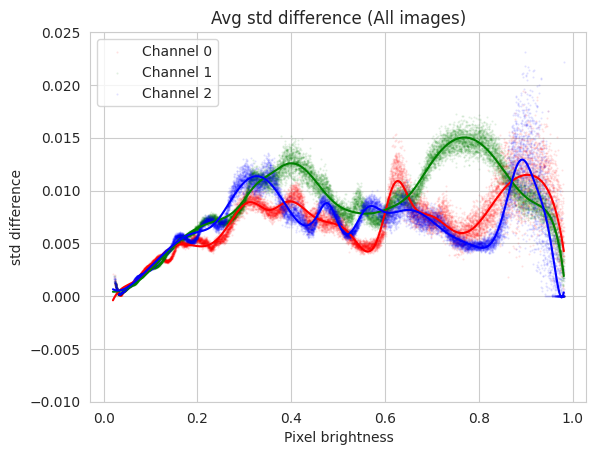

In [45]:
# Plot the original data and the fitted curve
x_fit = np.linspace(std_diff_per_brightness_r_negated[:,0].min(), std_diff_per_brightness_r_negated[:,0].max(), 400)
plt.scatter(std_diff_per_brightness_r_negated[:,0], std_diff_per_brightness_r_negated[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
plt.scatter(std_diff_per_brightness_g1_negated[:,0], std_diff_per_brightness_g1_negated[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
plt.scatter(std_diff_per_brightness_b_negated[:,0], std_diff_per_brightness_b_negated[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
# plt.scatter(std_diff_per_brightness_g2_negated[:,0], std_diff_per_brightness_g2_negated[:,1], s=0.3, color='purple', label="Channel 3", alpha=0.1)
plt.plot(x_fit, spline_r(x_fit), color='red')
plt.plot(x_fit, spline_g1(x_fit), color='green')
plt.plot(x_fit, spline_b(x_fit), color='blue')
# plt.plot(x_fit, spline_g2(x_fit), color='purple')
plt.title("Avg std difference (All images)")
plt.xlabel("Pixel brightness")
plt.ylabel("std difference")
plt.legend()
plt.ylim(-0.01, 0.025)



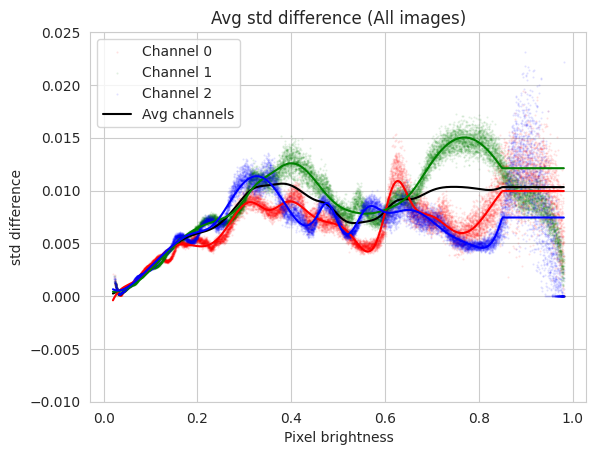

In [51]:
def f(array):
    return np.where(array > 0.85, 0.85, array)

    

# Plot the avg of the channels
avg_channels_splines = np.mean( np.array( [spline_r(f(x_fit)), spline_g1(f(x_fit)), spline_b(f(x_fit)), spline_g2(f(x_fit))] ), axis=0)
plt.scatter(std_diff_per_brightness_r_negated[:,0], std_diff_per_brightness_r_negated[:,1], s=0.3, color='red', label="Channel 0", alpha=0.1)
plt.scatter(std_diff_per_brightness_g1_negated[:,0], std_diff_per_brightness_g1_negated[:,1], s=0.3, color='green', label="Channel 1", alpha=0.1)
plt.scatter(std_diff_per_brightness_b_negated[:,0], std_diff_per_brightness_b_negated[:,1], s=0.3, color='blue', label="Channel 2", alpha=0.1)
# plt.scatter(std_diff_per_brightness_g2_negated[:,0], std_diff_per_brightness_g2_negated[:,1], s=0.3, color='purple', label="Channel 3", alpha=0.1)
plt.plot(x_fit, avg_channels_splines, color='black', label="Avg channels")
plt.plot(x_fit, spline_r(f(x_fit)), color='red')
plt.plot(x_fit, spline_g1(f(x_fit)), color='green')
plt.plot(x_fit, spline_b(f(x_fit)), color='blue')

plt.title("Avg std difference (All images)")
plt.xlabel("Pixel brightness")
plt.ylabel("std difference")
plt.legend()
plt.ylim(-0.01, 0.025)
plt.show()

In [46]:
# Save the negated data
np.save("std_diff_per_brightness_channel_0.npy", std_diff_per_brightness_r_negated)
np.save("std_diff_per_brightness_channel_1.npy", std_diff_per_brightness_g1_negated)
np.save("std_diff_per_brightness_channel_2.npy", std_diff_per_brightness_b_negated)
np.save("std_diff_per_brightness_channel_3.npy", std_diff_per_brightness_g2_negated)